# 02 - Data Preprocessing

This notebook handles data cleaning and validation.

## Objectives:
- Handle missing values
- Remove duplicates
- Handle outliers
- Data type conversions
- Data validation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load the raw data
df = pd.read_csv('../data/raw/movies_dataset_revenue.csv')
print(f"Original shape: {df.shape}")

Original shape: (11263, 22)


In [2]:
# Log transform the target variable
df['revenue'] = np.log1p(df['revenue'])

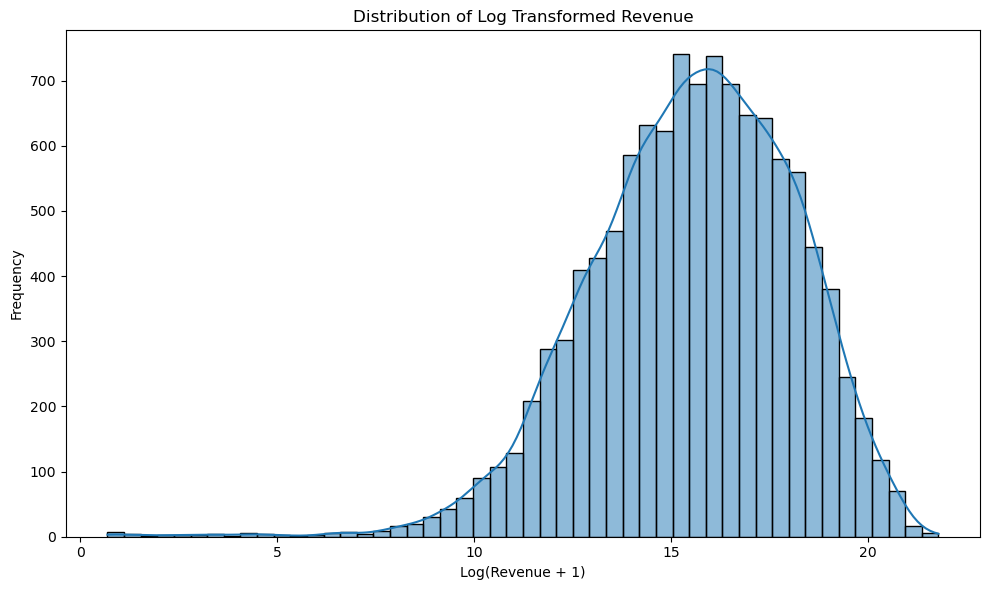

In [3]:
# Visualize the distribution of revenue after log transformation
plt.figure(figsize=(10, 6))
sns.histplot(df['revenue'], bins=50, kde=True)
plt.title('Distribution of Log Transformed Revenue')
plt.xlabel('Log(Revenue + 1)')  
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**Key Insights:**


In [4]:
# Handle missing values - Impute zero budget with median by genre
print("Zero budget records:", df[df['budget'] == 0].shape[0])

# Create flag for imputed budget values
df['budget_imputed'] = (df['budget'] == 0).astype(int)

# Parse genres (they are comma-separated strings)
# Create a dataframe with one row per genre for budget calculation
genre_budget_data = []
for idx, row in df.iterrows():
    if pd.notna(row['genres']):
        genres = str(row['genres']).split(', ')
        for genre in genres:
            genre_budget_data.append({
                'genre': genre,
                'budget': row['budget']
            })

# Calculate median budget by genre (excluding zero budgets)
genre_df = pd.DataFrame(genre_budget_data)
genre_medians = genre_df[genre_df['budget'] > 0].groupby('genre')['budget'].median()

print("\nMedian budget by genre:")
print(genre_medians)

# Function to impute budget based on genres
def impute_budget(row):
    if row['budget'] > 0:  # Keep non-zero budgets
        return row['budget']
    
    if pd.notna(row['genres']):
        genres = str(row['genres']).split(', ')
        # Get median budgets for all genres
        budgets_for_genres = [genre_medians.get(g) for g in genres if g in genre_medians.index]
        budgets_for_genres = [b for b in budgets_for_genres if pd.notna(b)]
        
        if budgets_for_genres:
            return np.median(budgets_for_genres)
    
    # Fallback: use overall median for non-zero budgets
    return genre_df[genre_df['budget'] > 0]['budget'].median()

# Apply imputation
df['budget'] = df.apply(impute_budget, axis=1)

print(f"\nZero budgets after imputation: {(df['budget'] == 0).sum()}")
print(f"Total records imputed: {df['budget_imputed'].sum()}")
print(f"Budget range after imputation: [{df['budget'].min():.0f}, {df['budget'].max():.0f}]")

Zero budget records: 4270

Median budget by genre:
genre
Action             28000000.0
Adventure          43000000.0
Animation          35000000.0
Comedy             13050000.0
Crime              15000000.0
Documentary         2000000.0
Drama              10000000.0
Family             34000000.0
Fantasy            35000000.0
History            18000000.0
Horror              8000000.0
Music              15000000.0
Mystery            15000000.0
Romance            12000000.0
Science Fiction    38000000.0
TV Movie            4600000.0
Thriller           15000000.0
War                18000000.0
Western            25000000.0
Name: budget, dtype: float64

Zero budgets after imputation: 0
Total records imputed: 4270
Budget range after imputation: [1, 489900000]


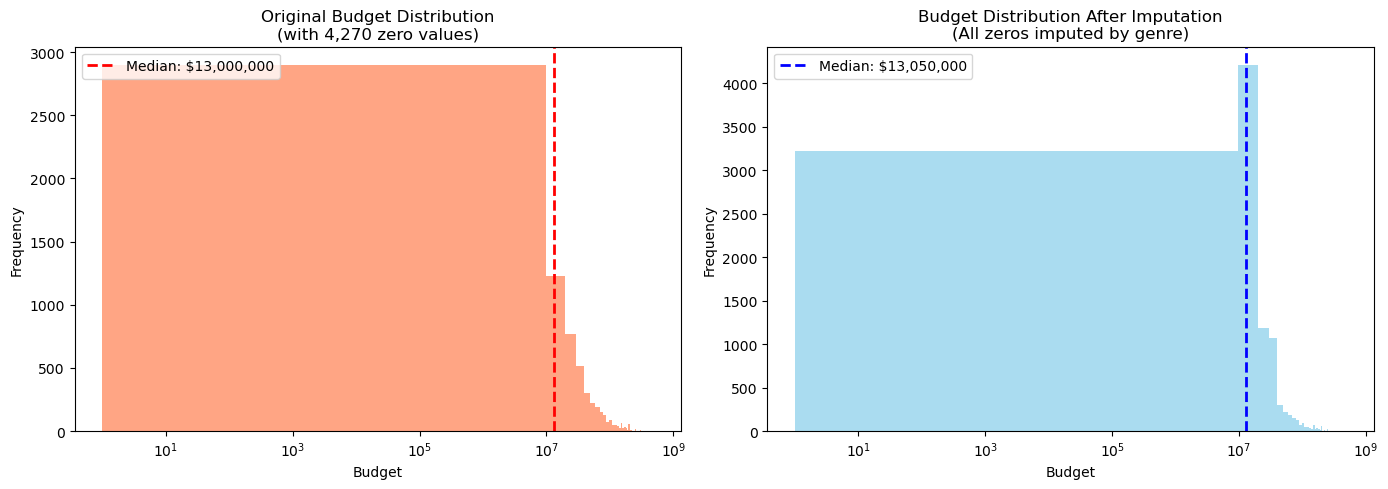

In [5]:
# Visualize budget imputation results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original data (before imputation - from CSV)
df_original = pd.read_csv('../data/raw/movies_dataset_revenue.csv')

# Plot 1: Original budget distribution
axes[0].hist(df_original[df_original['budget'] > 0]['budget'], bins=50, color='coral', alpha=0.7)
axes[0].axvline(df_original[df_original['budget'] > 0]['budget'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: ${df_original[df_original['budget'] > 0]['budget'].median():,.0f}")
axes[0].set_xlabel('Budget')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Original Budget Distribution\n(with {(df_original["budget"] == 0).sum():,} zero values)')
axes[0].legend()
axes[0].set_xscale('log')

# Plot 2: Imputed budget distribution
axes[1].hist(df[df['budget'] > 0]['budget'], bins=50, color='skyblue', alpha=0.7)
axes[1].axvline(df[df['budget'] > 0]['budget'].median(), color='blue', linestyle='--', linewidth=2, label=f"Median: ${df[df['budget'] > 0]['budget'].median():,.0f}")
axes[1].set_xlabel('Budget')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Budget Distribution After Imputation\n(All zeros imputed by genre)')
axes[1].legend()
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()

**Key Insights:**
- Budget distribution is now continuous with no zero values
- Genre-based imputation preserves meaningful relationships (Animation $35M vs Documentary $2.6M)
- This flag can help the model learn if imputation affects predictions

In [6]:
# Log transformation Budget after handle missing values
df['budget'] = np.log1p(df['budget'])

In [7]:
# Handle missing value - Impute Unknow to production_companies, production_countntries
df['production_companies'] = df['production_companies'].fillna('Unknown')
df['production_countries'] = df['production_countries'].fillna('Unknown')

In [8]:
# Handle missing values - Remove records with missing values in genres, cast, poster_brightness, poster_saturation, poster_dom_r, poster_dom_g, poster_dom_b, production_companies
cols = ['genres', 'cast', 'poster_brightness', 'poster_saturation', 'poster_dom_r', 'poster_dom_g', 'poster_dom_b']
df.dropna(subset=cols, inplace=True)

df.isna().sum()

id                         0
title                      0
release_date               0
budget                     0
revenue                    0
runtime                    0
rating                     0
vote_count                 0
popularity                 0
genres                     0
production_companies       0
production_countries       0
director                   0
cast                       0
keywords                1487
original_language          0
collection              8710
poster_brightness          0
poster_saturation          0
poster_dom_r               0
poster_dom_g               0
poster_dom_b               0
budget_imputed             0
dtype: int64

**Key Insights:**
- The missing values in features `keywords` and `collection` will be handle at feature-engineering step.

In [9]:
# Scale data
numeric_cols = ['budget', 'runtime', 'rating', 'vote_count', 'popularity']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [10]:
# Save preprocessed data
df.to_csv('../data/processed/movies_preprocessed.csv', index=False)
print(f"Shape after preprocesising: {df.shape}")
print("Data saved to ../data/processed/movies_preprocessed.csv")

Shape after preprocesising: (11242, 23)
Data saved to ../data/processed/movies_preprocessed.csv
